In [117]:
import random
import os
import xgboost
import shap
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns

from sklearn.linear_model    import LinearRegression
from sklearn.ensemble        import RandomForestRegressor
from sklearn.metrics         import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn                 import metrics
from sklearn.decomposition   import PCA
from sklearn.utils           import resample

In [2]:
%run featimp

# <center>Feature Importance</center>

<center>May 9, Eileen Wang</center>

## Context

<strong>1. Intro </strong>
- What is Feature Importance?
- Dataset description and loading

<strong>2. Spearman's rank correlation coefficient </strong>
- Introduction and Implementation
- Visualization

<strong>3. Model-based Feature Importance </strong>
- Drop column importance
- Permutation importance

<strong>4. Comparing strategies on models </strong>
- Introduction and Implementation
- Visualization

<strong>5. Automatic feature selection algorithm </strong>
- Introduction and Implementation
- Visualization

<strong>6. Variance and empirical p-values for feature importances </strong>
- Variance Visualization
- Empirical p-values

<strong>7. Summary </strong>

## Intro

### What is Feature Importance?

Imagine that you are dealing with a dataset with more than ten thousand features. Some features are just random noise, and some are highly relatived to each others, and some are super influential to your prediction, how can we weed out those unimportant features? Well, we always depend on numbers. So we have to find a way to quantize the importance of each feature and rank them by the number. As the result, there are some useful ways to do so and we will try them in this report.

### Dataset description and loading

In order to focus on feature importance selection, I will use our old friend, Boston dataset, to do demonstrations since it's relatively simple that we can avoid complex data cleaning. Let's load it first!

In [177]:
from sklearn.datasets import load_boston
X, y = load_boston(return_X_y=True)

We now have 13 features in this dataset.

In [157]:
col_names = load_boston().feature_names
col_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [165]:
column_dict={}
for index,col in enumerate(col_names):
    column_dict[index] = col
column_dict 

{0: 'CRIM',
 1: 'ZN',
 2: 'INDUS',
 3: 'CHAS',
 4: 'NOX',
 5: 'RM',
 6: 'AGE',
 7: 'DIS',
 8: 'RAD',
 9: 'TAX',
 10: 'PTRATIO',
 11: 'B',
 12: 'LSTAT'}

## Spearman's rank correlation coefficient

### Introduction and Implementation

The algorithm is pretty simple here. Just rank the features by its Spearman's rank correlation coefficient. However, this method suffers from codependent features. To deal with the issue, we use minimal-redundancy-maximal-relevance (mRMR), the idea behind this is that we rank our features not only by their relevance but also by their redundancy. The formula looks like:
<img src="mRMR.png" alt="Drawing" style="width: 600px;"/>
The I function here is aim to get the mutual information from features. Here we will use Spearman's rank correlation coefficient to het such infomation.

In [7]:
sfi = SpearFeatureImportance()
sfi.fit(X,y)
scores = sfi.score()

In [162]:
df_spear = pd.DataFrame(list(zip(col_names, scores)),columns =['column', 'score'])
df_spear['score'] = df_spear['score'].apply(np.abs)
df_spear['rank'] = df_spear['score'].rank(ascending=False)

In [163]:
df_spear = df_spear.sort_values('rank')
df_spear

,column,score,rank
12,LSTAT,0.852914,1.0
5,RM,0.633576,2.0
2,INDUS,0.578255,3.0
4,NOX,0.562609,4.0
9,TAX,0.562411,5.0
0,CRIM,0.558891,6.0
10,PTRATIO,0.555905,7.0
6,AGE,0.547562,8.0
7,DIS,0.445857,9.0
1,ZN,0.438179,10.0


### Visualization

The following graph shows the feature importances calculated by Spearman's rank correlation coefficient. We can see that LSTAT is the most relevant to our prediction and CHAS is more unimportant.

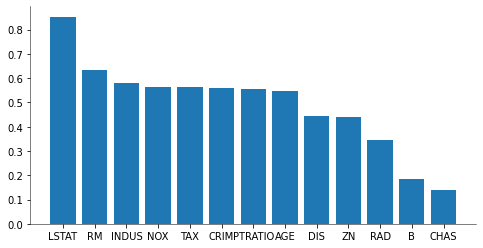

In [164]:
fig, ax = plt.subplots(figsize=(8,4))

ax.bar(df_spear.column, df_spear.score)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(.5)
ax.spines['bottom'].set_linewidth(.5)

ax.set_xticks(df_spear.column)
plt.show()

Next, we move on to deal with codependence. Let's check the heatmap of Spearman's rank correlation coefficient among our features. Some features have relatively high coefficient like AGE and NOX.

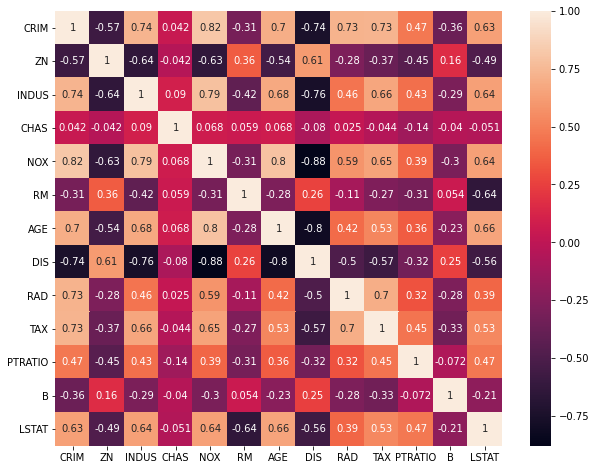

In [159]:
boston_df = pd.DataFrame(X,columns =col_names)
corr = boston_df.corr(method = 'spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot = True)
plt.show()

In [166]:
features, X_s = sfi.mRMR(13)
feature_col =[]
for index in features:
    feature_col.append(column_dict[index])

In [167]:
feature_col

['RM',
 'B',
 'DIS',
 'PTRATIO',
 'ZN',
 'CHAS',
 'RAD',
 'CRIM',
 'INDUS',
 'NOX',
 'AGE',
 'TAX',
 'LSTAT']

After mRMR, we got a list of final choice.

## Model-based Feature Importance

If we already selected a model, we can get feature importances by fitting the model. The idea is that we drop or permute the target column to see the difference in out metric, and take this as its feature importance. To keep things simple, we use linear regression and mean absolute error(MSE) as out model and metric here.

### Drop column importance

The brute-force way is dropping target column directly.

In [19]:
lr = LinearRegression()
metric = mean_absolute_error
X = pd.DataFrame(X)

In [36]:
drop_score = dropcol_importances(lr, metric, X, y)
df_drop = pd.DataFrame(list(zip(col_names, drop_score)),
               columns =['column', 'score'])
df_drop['rank'] = df_drop['score'].rank(ascending=False)
df_drop = df_drop.sort_values('rank')
df_drop

,column,score,rank
6,AGE,0.000231,1.0
2,INDUS,-0.001387,2.0
3,CHAS,-0.020696,3.0
0,CRIM,-0.028138,4.0
8,RAD,-0.041385,5.0
9,TAX,-0.042306,6.0
4,NOX,-0.053274,7.0
1,ZN,-0.059844,8.0
11,B,-0.085443,9.0
7,DIS,-0.158841,10.0


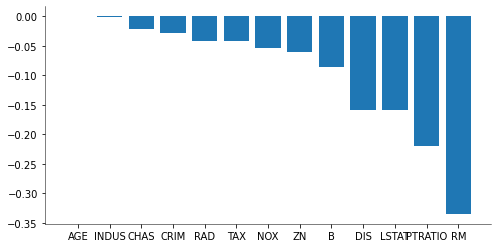

In [38]:
fig, ax = plt.subplots(figsize=(8,4))

ax.bar(df_drop.column, df_drop.score)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(.5)
ax.spines['bottom'].set_linewidth(.5)

ax.set_xticks(df_drop.column)
plt.show()

As we can see, drop any columns in our dataset will do negetive impact on our model. This method is easy, simple and direct but it has a drawback that we have to fit the model every time which is very computation expensive.

### Permutation importance

There is a more smart way than dropping the column -- we permute it. To illustrate, we break the relationship between  target column and other columns but keep the distribution. By doing so, we can get similar result as dropping it but save the computation time on refitting models.

In [37]:
per_score = permutation_importances(lr, metric, X, y)
df_per = pd.DataFrame(list(zip(col_names, per_score)),
               columns =['column', 'score'])
df_per['rank'] = df_per['score'].rank(ascending=False)
df_per = df_per.sort_values('rank')
df_per

,column,score,rank
6,AGE,0.001164,1.0
2,INDUS,-0.006160,2.0
3,CHAS,-0.077577,3.0
11,B,-0.183113,4.0
0,CRIM,-0.192629,5.0
1,ZN,-0.199838,6.0
10,PTRATIO,-0.754291,7.0
4,NOX,-0.822739,8.0
9,TAX,-0.861189,9.0
8,RAD,-0.965287,10.0


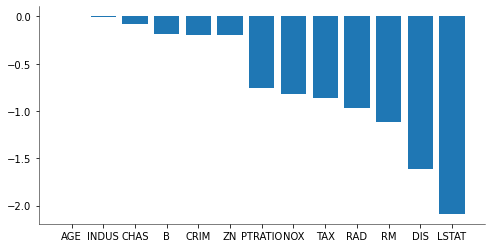

In [39]:
fig, ax = plt.subplots(figsize=(8,4))

ax.bar(df_per.column, df_per.score)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(.5)
ax.spines['bottom'].set_linewidth(.5)

ax.set_xticks(df_per.column)
plt.show()

## Comparing strategies on models

### Introduction and Implementation

In this part, we will use three different models and two feature importances technics -- Spearman's rank correlation coefficient and PCA (from scikit learn library) -- to find out how many features do we need. only thing we need to do here is calculate the average validation score on models fitted by k features.

In [78]:
def plot_comparing(model, top_k):
    result_spear=[]
    result_pca=[]
    for k in range(1,top_k+1):
        clf = model
        X_top_k = X[list(df_spear[df_spear['rank'] <=k]['column'])]
        score_list = cross_val_score(clf, X_top_k, y, cv=5, scoring='neg_mean_absolute_error')
        avg_score = score_list.sum()/len(score_list)
        result_spear.append(avg_score)

        pca = PCA(n_components=k)
        X_top_k_PCA = pca.fit_transform(X)
        score_list = cross_val_score(clf, X_top_k_PCA, y, cv=5, scoring='neg_mean_absolute_error')
        avg_score = score_list.sum()/len(score_list)
        result_pca.append(avg_score)
    
    fig, ax = plt.subplots(figsize=(4,3))

    ax.plot(range(1,top_k+1),result_spear,'s-',markersize=7, c='grey',fillstyle='none',label="Spearman",lw=1.5) 
    ax.plot(range(1,top_k+1),result_pca,'^-',markersize=8,label="PCA",lw=1.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)

    plt.legend()
    plt.show()

### Visualization

The following line plots show the fact that as we put more and more features to our model, the performance gets better, which is consistent to what we got on model-based feature importance selection process. Then we will compare the result to shapley values byt utilizing SHAP library.

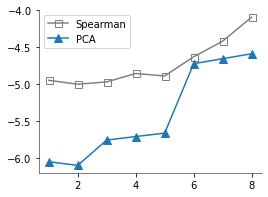

In [79]:
lr = LinearRegression()
plot_comparing(lr, 8)

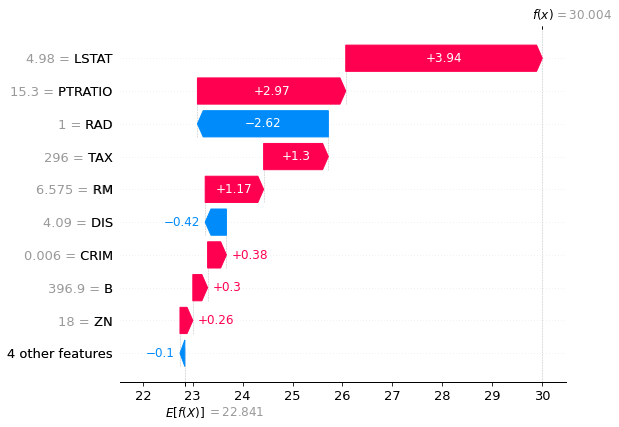

In [197]:
model = LinearRegression().fit(X, y)
X100 = shap.utils.sample(X, 100)
explainer = shap.Explainer(model.predict,X100)
shap_values = explainer(X)
shap.plots.waterfall(shap_values[0])

In [198]:
shap.initjs()
shap.plots.force(shap_values[0])

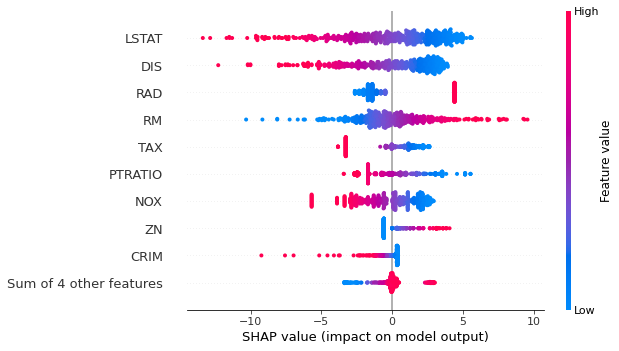

In [199]:
shap.initjs()
shap.plots.beeswarm(shap_values)

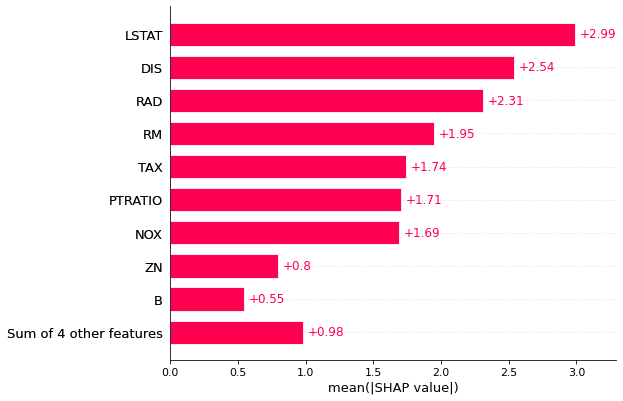

In [200]:
shap.plots.bar(shap_values)

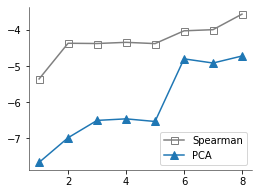

In [80]:
rf = RandomForestRegressor() 
plot_comparing(rf, 8)

Permutation explainer: 507it [01:46,  4.33it/s]                         


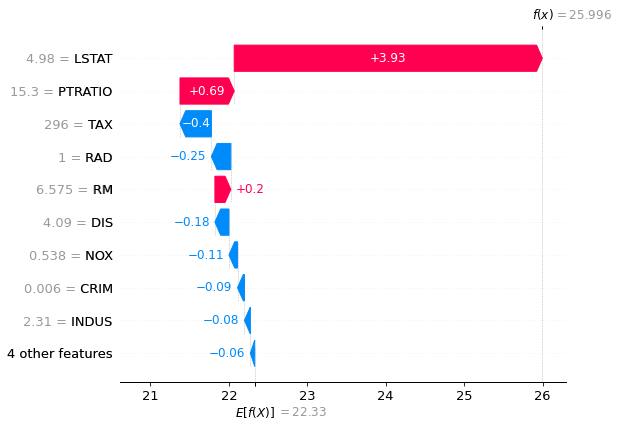

In [201]:
model = RandomForestRegressor().fit(X, y)
X100 = shap.utils.sample(X, 100)
explainer = shap.Explainer(model.predict,X100)
shap_values = explainer(X)
shap.plots.waterfall(shap_values[0])

In [202]:
shap.initjs()
shap.plots.force(shap_values[0])

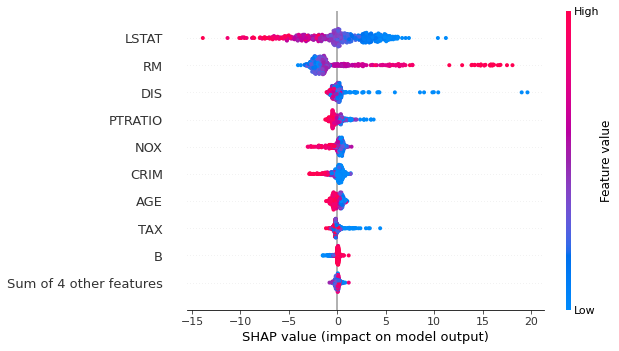

In [203]:
shap.initjs()
shap.plots.beeswarm(shap_values)

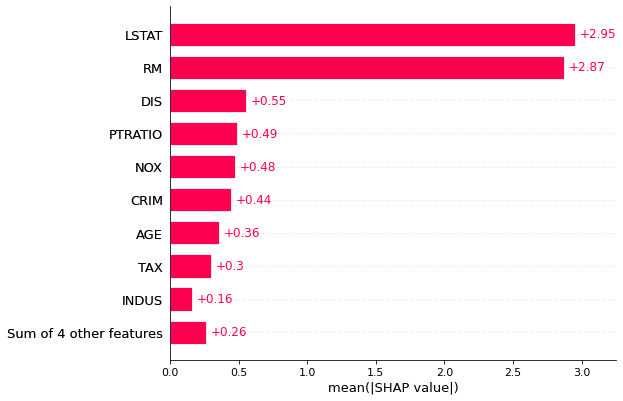

In [204]:
shap.plots.bar(shap_values)

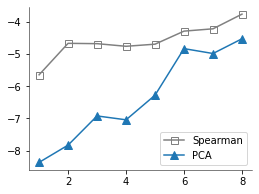

In [81]:
xgb = xgboost.XGBRegressor()
plot_comparing(xgb, 8)

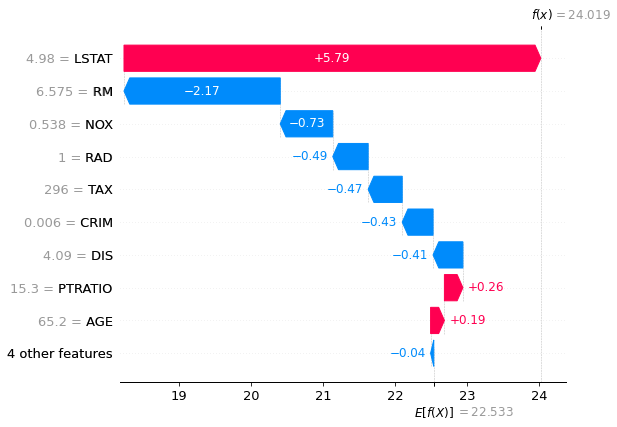

In [205]:
model = xgboost.XGBRegressor().fit(X, y)
explainer = shap.Explainer(model)
shap_values = explainer(X)
shap.plots.waterfall(shap_values[0])

In [206]:
shap.initjs()
shap.plots.force(shap_values[0])

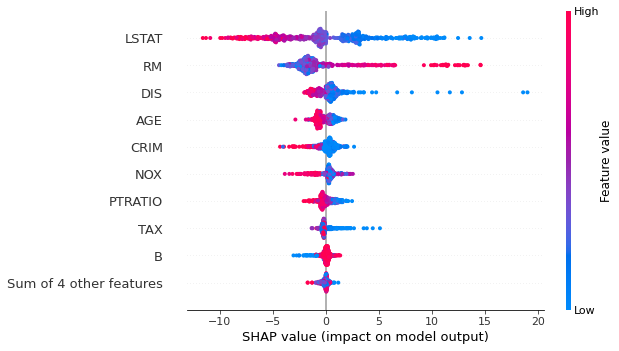

In [207]:
shap.initjs()
shap.plots.beeswarm(shap_values)

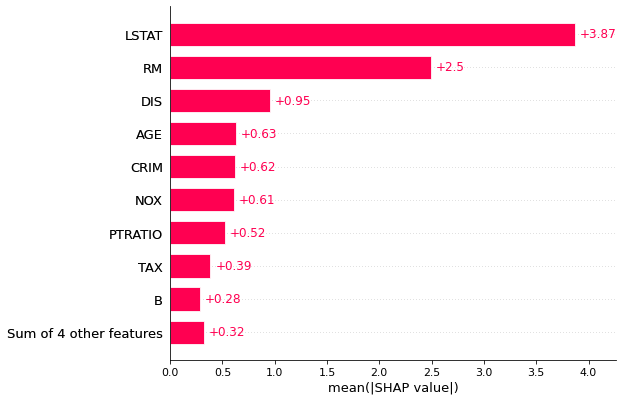

In [208]:
shap.plots.bar(shap_values)

## Automatic feature selection algorithm

### Introduction and Implementation

Now we want to try another way to find best fit for our model. The algorithm here is as following:
1. calculate validation error on the whole dataset as the baseline
2. drop the least important features and calculate validation error again 
3. if the error get worse, stop and take the columns in previous step as the best fit.

In [182]:
lr = LinearRegression()
metric = mean_absolute_error
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
lr.fit(X_train,y_train)
validation_error = metric(y_val, lr.predict(X_val))


for i in range(len(X.columns),1,-1):
    lr = LinearRegression()
    X_drop = X[list(df_spear[df_spear['rank'] < i]['column'])]
    X_train, X_val, y_train, y_val = train_test_split(X_drop, y, test_size=0.2)
    lr.fit(X_train,y_train)
    new_validation_error = metric(y_val, lr.predict(X_val))
    
    if new_validation_error > validation_error:
        result = list(df_spear[df_spear['rank'] < i+1]['column'])
        break
    else:
        validation_error = new_validation_error
print(result)

['LSTAT', 'RM', 'INDUS', 'NOX', 'TAX', 'CRIM', 'PTRATIO', 'AGE', 'DIS', 'ZN', 'RAD', 'B', 'CHAS']


In this case, we got worse score at the first drop so it suggest us to keep every features.

### Visualization

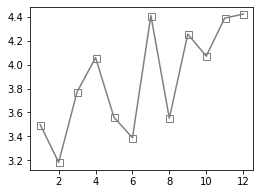

In [185]:
lr = LinearRegression()
metric = mean_absolute_error
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
lr.fit(X_train,y_train)
validation_error = metric(y_val, lr.predict(X_val))

val_err=[]
for i in range(len(X.columns),1,-1):
    lr = LinearRegression()
    X_drop = X[list(df_spear[df_spear['rank'] < i]['column'])]
    X_train, X_val, y_train, y_val = train_test_split(X_drop, y, test_size=0.2)
    lr.fit(X_train,y_train)
    new_validation_error = metric(y_val, lr.predict(X_val))
    val_err.append(new_validation_error)
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(range(1,len(val_err)+1),val_err,'s-',markersize=7, c='grey',fillstyle='none',label="Spearman",lw=1.5)
plt.show()

## Variance and empirical p-values for feature importances

Now we want to know to what degree our feature importance is reliable. In order to answer that, calculating the variance or standard deviation and p-value is useful. In this part, we use bootstrapping method on our dataset to get standard deviation.

In [144]:
result=[]
for _ in range(1000):
    data = X
    data['y'] = y
    boot = resample(data, replace=True, n_samples=len(data)//5)
    boot_X = np.array(boot.drop(columns=['y'], axis=1))
    boot_y = np.array(boot['y'])
    sfi = SpearFeatureImportance()
    sfi.fit(boot_X, boot_y)
    scores = sfi.score()
    result.append(scores)

In [149]:
std = np.std(np.array(result), axis=0)

In [150]:
sfi = SpearFeatureImportance()
sfi.fit(X,y)
scores = sfi.score()
df_spear = pd.DataFrame(list(zip(col_names, scores)),
               columns =['column', 'score'])
df_spear['rank'] = df_spear['score'].rank(ascending=False)
df_spear['std']=std
df_spear

,column,score,rank,std
0,CRIM,-0.558891,9.0,0.081765
1,ZN,0.438179,3.0,0.077604
2,INDUS,-0.578255,12.0,0.075246
3,CHAS,0.140612,5.0,0.100605
4,NOX,-0.562609,11.0,0.074067
5,RM,0.633576,1.0,0.082331
6,AGE,-0.547562,7.0,0.078061
7,DIS,0.445857,2.0,0.092741
8,RAD,-0.346776,6.0,0.091992
9,TAX,-0.562411,10.0,0.077830


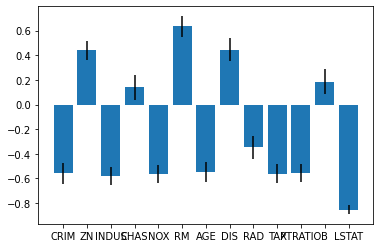

In [153]:
plt.bar(df_spear['column'], df_spear['score'], yerr= df_spear['std'])
plt.show()

As for p-value, first thind we have to do is to create a null distribution, which means shuffling y and then compute the feature importances again. To do so, I want to borrow useful functions from a amazing [Kaggle notebook](https://www.kaggle.com/ogrellier/feature-selection-with-null-importances) and do some changes to fit my case.

In [224]:
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
def get_feature_importances(data, shuffle, seed=None):
    # Gather real features
    train_features = [f for f in data if f not in ['y']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = data['y'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['y'].copy().sample(frac=1.0)
    

    sfi = SpearFeatureImportance()
    sfi.fit(np.array(data[train_features]),np.array(y))

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = sfi.score()
    
    return imp_df

In [225]:
null_imp_df = pd.DataFrame()
nb_runs = 80
import time
start = time.time()
dsp = ''
data = X
data['y'] = y
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=data, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with   80 of   80 (Spent   0.1 min)

In [227]:
null_imp_df.head()

,feature,importance_gain,run
0,CRIM,-0.080958,1
1,ZN,0.083073,1
2,INDUS,-0.066545,1
3,CHAS,-0.014717,1
4,NOX,-0.062999,1


In [239]:
import matplotlib.gridspec as gridspec
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)

    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['column'] == feature_, 'score'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())

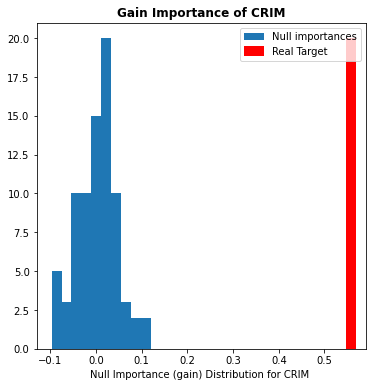

In [240]:
display_distributions(actual_imp_df_=df_spear, null_imp_df_=null_imp_df, feature_='CRIM')

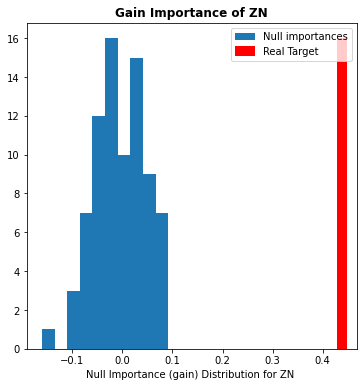

In [241]:
display_distributions(actual_imp_df_=df_spear, null_imp_df_=null_imp_df, feature_='ZN')

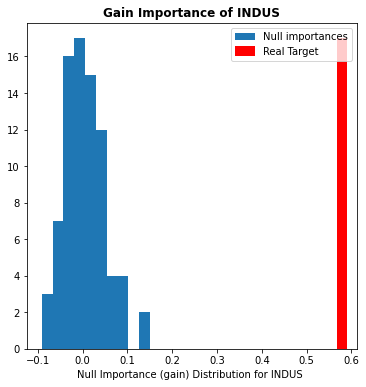

In [242]:
display_distributions(actual_imp_df_=df_spear, null_imp_df_=null_imp_df, feature_='INDUS')

I simply take three features ramdomly to see the p-value distribution. we can see that the p-value obviously far lower than 5%, which means it is significant.

## Summary

Feature selecting process is crucial to model training. Unrelated features cause noise and bias to model and make the prediction unreliable. In this report, we used several different methods to calculate feature importance, including Spearman's rank correlation coefficient, PCA and model-based, and implemented strategy to get top features and reliability of our numbers.